# Capstone Project

## Modelling with LSTM

In [3]:
#importing Libraries
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# import keras
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Loading the data

In [4]:
df = pd.read_csv('WELFake_Dataset.csv')
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


## Data pre-processing

In [5]:
#Dropping "Unnamed: 0" column
 
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [7]:
#check for null values
df.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [8]:
# Drop rows with null values
df.dropna(subset=['title', 'text'], inplace=True)

In [9]:
# Combine 'title' and 'text' columns
df['content'] = df['title'] + " " + df['text']

## Text Cleaning

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Expand contractions (e.g., "isn't" -> "is not")
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    
    # Tokenize and remove stopwords, apply lemmatization
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Rejoin tokens into a single string
    text = ' '.join(tokens)
    
    return text

# Apply preprocessing
df['content'] = df['content'].apply(preprocess_text)


## Tokenize and Pad Text

In [11]:
# Parameters for tokenization and padding
max_words = 20000  # Vocabulary size
max_len = 200      # Maximum sequence length

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['content'])
sequences = tokenizer.texts_to_sequences(df['content'])

# Pad sequences to ensure uniform input size
X = pad_sequences(sequences, maxlen=max_len)
y = df['label'].values

## Split the Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building and Compiling the LSTM Model


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
embedding_dim = 100  # Embedding vector size

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True),  # Use return_sequences for stacked LSTM
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification (0=fake, 1=real)
])


# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2024-10-31 18:54:46.561990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-31 18:54:46.562519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-31 18:54:46.563303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

## Train the model

In [48]:
epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/10


2024-10-31 14:31:46.020835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-31 14:31:46.021458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-31 14:31:46.022318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

895/895 [==============================] - ETA: 0s - loss: 0.2059 - accuracy: 0.9197

2024-10-31 14:36:23.597662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-31 14:36:23.598675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-31 14:36:23.599320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

895/895 [==============================] - 297s 329ms/step - loss: 0.2059 - accuracy: 0.9197 - val_loss: 0.1444 - val_accuracy: 0.9474
Epoch 2/10
895/895 [==============================] - 315s 352ms/step - loss: 0.0990 - accuracy: 0.9665 - val_loss: 0.1409 - val_accuracy: 0.9565
Epoch 3/10
895/895 [==============================] - 305s 341ms/step - loss: 0.0499 - accuracy: 0.9844 - val_loss: 0.1622 - val_accuracy: 0.9572
Epoch 4/10
895/895 [==============================] - 310s 346ms/step - loss: 0.0290 - accuracy: 0.9910 - val_loss: 0.1761 - val_accuracy: 0.9527
Epoch 5/10
895/895 [==============================] - 322s 360ms/step - loss: 0.0249 - accuracy: 0.9927 - val_loss: 0.1857 - val_accuracy: 0.9432
Epoch 6/10
895/895 [==============================] - 315s 352ms/step - loss: 0.0169 - accuracy: 0.9946 - val_loss: 0.2493 - val_accuracy: 0.9304
Epoch 7/10
895/895 [==============================] - 322s 360ms/step - loss: 0.0517 - accuracy: 0.9806 - val_loss: 0.1969 - val_accura

## Evaluation

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict and evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

2024-10-31 15:25:48.729711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-31 15:25:48.730316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-31 15:25:48.731304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

448/448 [==============================] - 31s 68ms/step
Accuracy: 0.9552697791445345
Precision: 0.9561002631214514
Recall: 0.9553064895530649
F1 Score: 0.955703211517165


Text(70.72222222222221, 0.5, 'Real Labels')

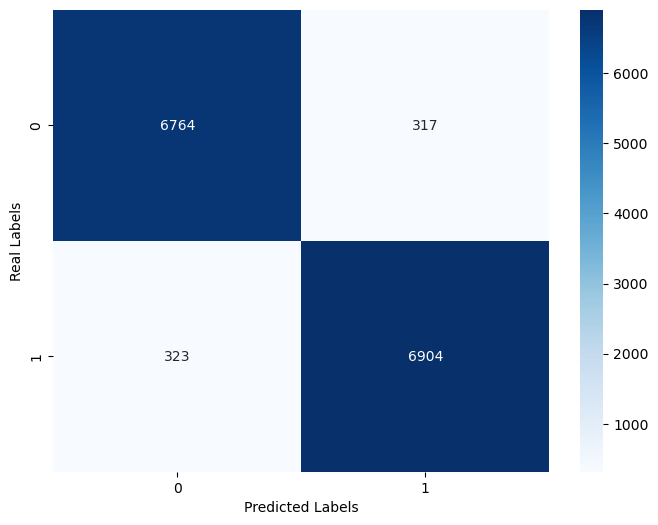

In [50]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## Create a pipeline with preprocessor and LTSM model class

In [52]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_length=300, vocab_size=50000):
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.tokenizer = None

    def clean_text(self, text):
        # Lowercase
        text = text.lower()
        
        # Expand contractions
        text = re.sub(r"n't", " not", text)
        text = re.sub(r"'re", " are", text)
        text = re.sub(r"'s", " is", text)
        text = re.sub(r"'d", " would", text)
        text = re.sub(r"'ll", " will", text)
        text = re.sub(r"'t", " not", text)
        text = re.sub(r"'ve", " have", text)
        text = re.sub(r"'m", " am", text)
        
        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        
        # Remove special characters and numbers
        text = re.sub(r'\W', ' ', text)
        text = re.sub(r'\d', '', text)
        
        # Tokenize and remove stopwords, apply lemmatization
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        
        # Rejoin tokens into a single string
        text = ' '.join(tokens)
        
        return text

    def fit(self, X, y=None):
        # Clean text for each entry in X
        X_cleaned = [self.clean_text(text) for text in X]
        # Initialize and fit the tokenizer
        self.tokenizer = Tokenizer(num_words=self.vocab_size)
        self.tokenizer.fit_on_texts(X_cleaned)
        return self

    def transform(self, X, y=None):
        # Clean and tokenize text, then pad sequences
        X_cleaned = [self.clean_text(text) for text in X]
        X_tokenized = self.tokenizer.texts_to_sequences(X_cleaned)
        X_padded = pad_sequences(X_tokenized, maxlen=self.max_length)
        return X_padded

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam

def create_lstm_model(vocab_size, embedding_dim=100, max_len=300, lstm_units1=128, lstm_units2=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(LSTM(lstm_units1, return_sequences=True))  # First LSTM with return_sequences=True for stacking
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units2))  # Second LSTM layer
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [61]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline

# Define pipeline components
preprocessor = Preprocessor(max_length=300, vocab_size=50000)
lstm_model = KerasClassifier(
    build_fn=create_lstm_model, 
    vocab_size=50000, 
    embedding_dim=100, 
    max_len=300,
    lstm_units1=128, 
    lstm_units2=64, 
    dropout_rate=0.2, 
    learning_rate=0.001, 
    epochs=10, 
    batch_size=64, 
    verbose=1
)

# Create the pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lstm_model)
])

/var/folders/88/8c2dgq99663bpg_bf9dqpb0r0000gn/T/ipykernel_22277/3631149286.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasClassifier(


In [63]:
# Fit the pipeline on training data
pipe.fit(df['content'], df['label'])



2024-10-31 16:08:57.801402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-31 16:08:57.801893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-31 16:08:57.802596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-10-31 16:08:58.043342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-31 16:08:58.044081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-31 16:08:58.044929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1118/1118 [==============================] - 534s 476ms/step - loss: 0.2145 - accuracy: 0.9170
Epoch 2/10
1118/1118 [==============================] - 515s 461ms/step - loss: 0.1162 - accuracy: 0.9605
Epoch 3/10
1118/1118 [==============================] - 505s 451ms/step - loss: 0.0552 - accuracy: 0.9819
Epoch 4/10
1118/1118 [==============================] - 501s 448ms/step - loss: 0.0381 - accuracy: 0.9873
Epoch 5/10
1118/1118 [==============================] - 523s 468ms/step - loss: 0.0177 - accuracy: 0.9947
Epoch 6/10
1118/1118 [==============================] - 541s 484ms/step - loss: 0.0087 - accuracy: 0.9975
Epoch 7/10
1118/1118 [==============================] - 530s 474ms/step - loss: 0.0068 - accuracy: 0.9979
Epoch 8/10
1118/1118 [==============================] - 549s 491ms/step - loss: 0.0071 - accuracy: 0.9977
Epoch 9/10
1118/1118 [==============================] - 579s 518ms/step - loss: 0.0045 - accuracy: 0.9986
Epoch 10/10
1118/1118 [==============================] - 

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('classifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x160644310>)])

## Testing

In [ ]:
fake_news_example = """
BREAKING: Scientists discover that consuming chocolate three times a day will extend lifespan by 30 years!
According to a new report, researchers have found groundbreaking evidence that eating chocolate regularly can
drastically improve life expectancy and prevent almost all diseases. This new "miracle food" is said to be 
the ultimate health solution, and officials are now advising people to include it in their daily diets.
"""
# Example prediction
print(pipe.predict(pd.Series('fake_news_example ')))


2024-10-31 17:39:17.432314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-31 17:39:17.434099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-31 17:39:17.434863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 420ms/step
[[1]]


## Saving the Model with Keras

In [65]:
import tensorflow as tf
import pickle


model = pipe.named_steps['classifier'].model  # Get the Keras model from the pipeline
tokenizer = pipe.named_steps['preprocessor'].tokenizer  # Get the tokenizer from the preprocessor

# Save the Keras model
model.save('lstm_model.h5')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Training vs Validation loss

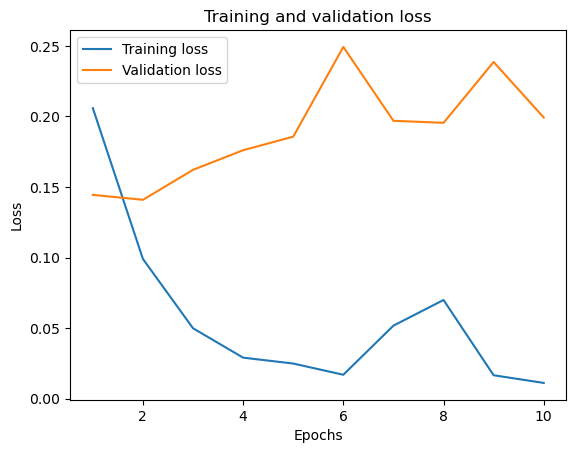

In [66]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

## Model Architecture plot

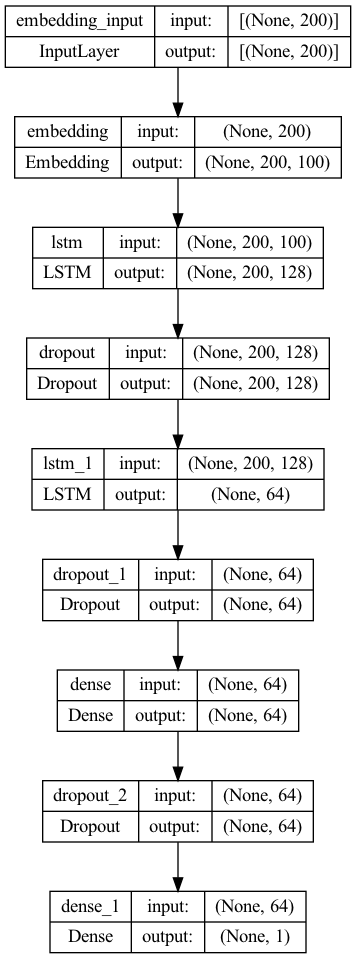

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="lstm_model.png", show_shapes=True, show_layer_names=True)
